In [1]:
!pip install -q segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.4 MB/s eta 0:00:00


In [2]:
import os
import glob
import numpy as np
import nibabel as nib
import cv2
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import segmentation_models_pytorch as smp

In [4]:
os.environ['KAGGLE_USERNAME'] = "olenamikhailova"

os.environ['KAGGLE_KEY'] = "KGAT_e8b5a4ccb83e496885c5e98432eb4846"

if not os.path.exists("./brats2020"):
    print("Downloading BraTS 2020...")
    !kaggle datasets download -d awsaf49/brats20-dataset-training-validation --force
    !unzip -q brats20-dataset-training-validation.zip -d ./brats2020
    print("Dataset Ready.")
else:
    print("Dataset already exists.")

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [01:17<00:00, 241MB/s]
100% 4.16G/4.16G [01:17<00:00, 57.3MB/s]
Dataset Ready.


In [5]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.image_size = image_size
        self.patient_dirs = sorted(glob.glob(os.path.join(root_dir, "**", "BraTS20_Training_*"), recursive=True))
        self.patient_dirs = [d for d in self.patient_dirs if os.path.isdir(d)]

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        p_dir = self.patient_dirs[idx]
        p_id = os.path.basename(p_dir)

        flair_path = os.path.join(p_dir, f"{p_id}_flair.nii")
        seg_path = os.path.join(p_dir, f"{p_id}_seg.nii")

        try:
            flair_vol = nib.load(flair_path).get_fdata()
            seg_vol = nib.load(seg_path).get_fdata()

            # Smart Slicing: Pick slice with most tumor
            tumor_counts = np.sum(seg_vol > 0, axis=(0, 1))
            if np.max(tumor_counts) > 0:
                slice_idx = np.argmax(tumor_counts)
            else:
                slice_idx = flair_vol.shape[2] // 2

            img = flair_vol[:, :, slice_idx]
            mask = seg_vol[:, :, slice_idx]

            # Normalization (0-1)
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

            # Resizing
            img = cv2.resize(img, (self.image_size, self.image_size))
            mask = np.where(mask > 0, 1.0, 0.0) # Binarize mask
            mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

            img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)
            mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

            return img_tensor, mask_tensor

        except Exception as e:
            return torch.zeros(3, 256, 256), torch.zeros(1, 256, 256)

In [6]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0, path='utility_model_unet.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({val_loss:.6f}). Saving model...')

In [7]:
from google.colab import files
print("Please upload 'utility_model_unet.pth'...")
uploaded = files.upload()

Please upload 'utility_model_unet.pth'...


Saving utility_model_unet (1).pth to utility_model_unet (1).pth


In [10]:
BATCH_SIZE = 16
EPOCHS = 30
PATIENCE = 5
LEARNING_RATE = 5e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = BraTSDataset(root_dir="./brats2020")
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)

if os.path.exists('utility_model_unet (1).pth'):
    print("Loading saved weights from yesterday...")
    model.load_state_dict(torch.load('utility_model_unet (1).pth'))
    print("Weights loaded successfully!")
else:
    print("Warning: Saved file not found. Training from scratch.")

criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
early_stopper = EarlyStopping(patience=PATIENCE, path='utility_model_unet (1).pth')

print(f"\nRESUMING TRAINING on {DEVICE}")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs, masks in loop:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            val_loss = criterion(preds, masks)
            val_running_loss += val_loss.item()

    avg_train = running_loss / len(train_loader)
    avg_val = val_running_loss / len(val_loader)

    print(f"\tTrain Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

    early_stopper(avg_val, model)

    if early_stopper.early_stop:
        print("\nEarly stopping triggered!")
        break

print("\nTraining Complete. Download your final model!")

Loading saved weights from yesterday...
Weights loaded successfully!

RESUMING TRAINING on cuda


Epoch 1/30: 100%|██████████| 21/21 [00:40<00:00,  1.95s/it, loss=0.224]


	Train Loss: 0.2235 | Val Loss: 0.2097
Validation loss decreased (0.209735). Saving model...


Epoch 2/30: 100%|██████████| 21/21 [00:41<00:00,  1.99s/it, loss=0.217]


	Train Loss: 0.2092 | Val Loss: 0.2010
Validation loss decreased (0.201000). Saving model...


Epoch 3/30: 100%|██████████| 21/21 [00:38<00:00,  1.85s/it, loss=0.158]


	Train Loss: 0.2000 | Val Loss: 0.1941
Validation loss decreased (0.194137). Saving model...


Epoch 4/30: 100%|██████████| 21/21 [00:37<00:00,  1.77s/it, loss=0.19]


	Train Loss: 0.1894 | Val Loss: 0.1867
Validation loss decreased (0.186712). Saving model...


Epoch 5/30: 100%|██████████| 21/21 [00:38<00:00,  1.83s/it, loss=0.169]


	Train Loss: 0.1795 | Val Loss: 0.1779
Validation loss decreased (0.177851). Saving model...


Epoch 6/30: 100%|██████████| 21/21 [00:40<00:00,  1.95s/it, loss=0.176]


	Train Loss: 0.1724 | Val Loss: 0.1709
Validation loss decreased (0.170922). Saving model...


Epoch 7/30: 100%|██████████| 21/21 [00:41<00:00,  1.97s/it, loss=0.193]


	Train Loss: 0.1652 | Val Loss: 0.1663
Validation loss decreased (0.166344). Saving model...


Epoch 8/30: 100%|██████████| 21/21 [00:41<00:00,  1.96s/it, loss=0.162]


	Train Loss: 0.1602 | Val Loss: 0.1629
Validation loss decreased (0.162881). Saving model...


Epoch 9/30: 100%|██████████| 21/21 [00:44<00:00,  2.12s/it, loss=0.148]


	Train Loss: 0.1516 | Val Loss: 0.1529
Validation loss decreased (0.152899). Saving model...


Epoch 10/30: 100%|██████████| 21/21 [00:43<00:00,  2.08s/it, loss=0.144]


	Train Loss: 0.1482 | Val Loss: 0.1483
Validation loss decreased (0.148256). Saving model...


Epoch 11/30: 100%|██████████| 21/21 [00:45<00:00,  2.18s/it, loss=0.138]


	Train Loss: 0.1397 | Val Loss: 0.1433
Validation loss decreased (0.143306). Saving model...


Epoch 12/30: 100%|██████████| 21/21 [00:46<00:00,  2.19s/it, loss=0.147]


	Train Loss: 0.1354 | Val Loss: 0.1391
Validation loss decreased (0.139097). Saving model...


Epoch 13/30: 100%|██████████| 21/21 [00:46<00:00,  2.20s/it, loss=0.13]


	Train Loss: 0.1326 | Val Loss: 0.1354
Validation loss decreased (0.135412). Saving model...


Epoch 14/30: 100%|██████████| 21/21 [00:47<00:00,  2.25s/it, loss=0.173]


	Train Loss: 0.1263 | Val Loss: 0.1307
Validation loss decreased (0.130692). Saving model...


Epoch 15/30: 100%|██████████| 21/21 [00:49<00:00,  2.35s/it, loss=0.117]


	Train Loss: 0.1206 | Val Loss: 0.1276
Validation loss decreased (0.127561). Saving model...


Epoch 16/30: 100%|██████████| 21/21 [00:49<00:00,  2.35s/it, loss=0.118]


	Train Loss: 0.1172 | Val Loss: 0.1238
Validation loss decreased (0.123752). Saving model...


Epoch 17/30: 100%|██████████| 21/21 [00:51<00:00,  2.46s/it, loss=0.15]


	Train Loss: 0.1124 | Val Loss: 0.1191
Validation loss decreased (0.119091). Saving model...


Epoch 18/30: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it, loss=0.0848]


	Train Loss: 0.1070 | Val Loss: 0.1144
Validation loss decreased (0.114376). Saving model...


Epoch 19/30: 100%|██████████| 21/21 [00:50<00:00,  2.43s/it, loss=0.0881]


	Train Loss: 0.1035 | Val Loss: 0.1105
Validation loss decreased (0.110498). Saving model...


Epoch 20/30: 100%|██████████| 21/21 [00:49<00:00,  2.37s/it, loss=0.0952]


	Train Loss: 0.1012 | Val Loss: 0.1091
Validation loss decreased (0.109068). Saving model...


Epoch 21/30: 100%|██████████| 21/21 [00:49<00:00,  2.35s/it, loss=0.0967]


	Train Loss: 0.0985 | Val Loss: 0.1128
EarlyStopping counter: 1 out of 5


Epoch 22/30: 100%|██████████| 21/21 [00:49<00:00,  2.34s/it, loss=0.0802]


	Train Loss: 0.0952 | Val Loss: 0.1068
Validation loss decreased (0.106812). Saving model...


Epoch 23/30: 100%|██████████| 21/21 [00:49<00:00,  2.34s/it, loss=0.0905]


	Train Loss: 0.0918 | Val Loss: 0.1035
Validation loss decreased (0.103521). Saving model...


Epoch 24/30: 100%|██████████| 21/21 [00:48<00:00,  2.33s/it, loss=0.0772]


	Train Loss: 0.0884 | Val Loss: 0.0977
Validation loss decreased (0.097742). Saving model...


Epoch 25/30: 100%|██████████| 21/21 [00:49<00:00,  2.34s/it, loss=0.0689]


	Train Loss: 0.0850 | Val Loss: 0.0963
Validation loss decreased (0.096266). Saving model...


Epoch 26/30: 100%|██████████| 21/21 [00:50<00:00,  2.41s/it, loss=0.0907]


	Train Loss: 0.0832 | Val Loss: 0.0944
Validation loss decreased (0.094437). Saving model...


Epoch 27/30: 100%|██████████| 21/21 [00:49<00:00,  2.38s/it, loss=0.0682]


	Train Loss: 0.0802 | Val Loss: 0.0931
Validation loss decreased (0.093129). Saving model...


Epoch 28/30: 100%|██████████| 21/21 [00:49<00:00,  2.37s/it, loss=0.0755]


	Train Loss: 0.0776 | Val Loss: 0.0921
Validation loss decreased (0.092135). Saving model...


Epoch 29/30: 100%|██████████| 21/21 [00:49<00:00,  2.37s/it, loss=0.076]


	Train Loss: 0.0758 | Val Loss: 0.0901
Validation loss decreased (0.090114). Saving model...


Epoch 30/30: 100%|██████████| 21/21 [00:49<00:00,  2.38s/it, loss=0.0786]


	Train Loss: 0.0729 | Val Loss: 0.0902
EarlyStopping counter: 1 out of 5

Training Complete. Download your final model!


Calculating Metrics on Validation Set...

FINAL RESULTS:
Average Dice Score: 0.9500 (Ideal: >0.85)
Average IoU Score:  0.9058  (Ideal: >0.75)

Visualizing predictions...


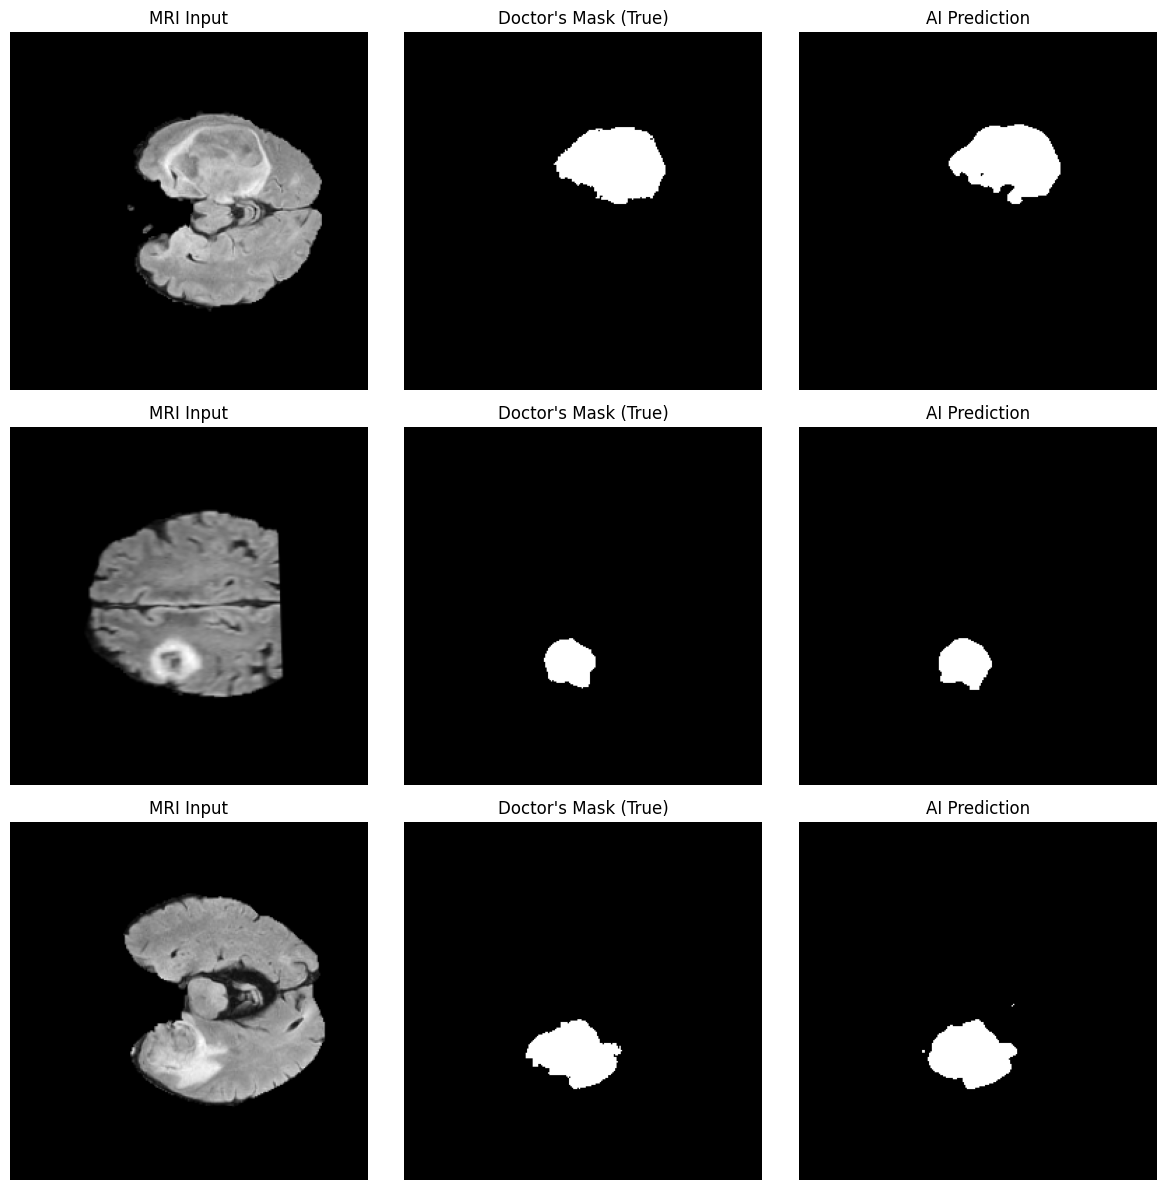

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def calculate_metrics(loader, model, device='cuda'):
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)

            # Get Prediction
            preds = model(imgs)
            preds = (torch.sigmoid(preds) > 0.5).float() # Threshold at 0.5 to make it binary (0 or 1)

            # Calculate Intersection & Union for every image in batch
            intersection = (preds * masks).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3))

            # Dice Score = 2 * Intersection / (Sum of pixels in both)
            dice = (2. * intersection + 1e-6) / (union + 1e-6)

            # IoU = Intersection / (Union - Intersection)
            iou = (intersection + 1e-6) / (union - intersection + 1e-6)

            dice_scores.extend(dice.cpu().numpy())
            iou_scores.extend(iou.cpu().numpy())

    return np.mean(dice_scores), np.mean(iou_scores)

def visualize_results(loader, model, device='cuda', num_samples=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        preds = model(imgs)
        preds = (torch.sigmoid(preds) > 0.5).float()

    plt.figure(figsize=(12, 4 * num_samples))
    for i in range(min(num_samples, len(imgs))):

        # Original Image (Take 1st channel only)
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(imgs[i][0].cpu(), cmap='gray')
        plt.title("MRI Input")
        plt.axis('off')

        # Ground Truth
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i][0].cpu(), cmap='gray')
        plt.title("Doctor's Mask (True)")
        plt.axis('off')

        # Model Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds[i][0].cpu(), cmap='gray')
        plt.title("AI Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Calculating Metrics on Validation Set...")
avg_dice, avg_iou = calculate_metrics(val_loader, model, DEVICE)

print(f"\nFINAL RESULTS:")
print(f"Average Dice Score: {avg_dice:.4f} (Ideal: >0.85)")
print(f"Average IoU Score:  {avg_iou:.4f}  (Ideal: >0.75)")

print("\nVisualizing predictions...")
visualize_results(val_loader, model, DEVICE)

## "Attacker" model


In [12]:
import os
import glob
import numpy as np
import nibabel as nib
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
ATTACK_BATCH_SIZE = 64
ATTACK_EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
class BraTSAttackerDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.image_size = image_size
        self.patient_dirs = sorted(glob.glob(os.path.join(root_dir, "**", "BraTS20_Training_*"), recursive=True))
        self.patient_dirs = [d for d in self.patient_dirs if os.path.isdir(d)]

        self.class_to_idx = {p_name: i for i, p_name in enumerate(self.patient_dirs)}

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        p_dir = self.patient_dirs[idx]
        p_id = os.path.basename(p_dir)
        flair_path = os.path.join(p_dir, f"{p_id}_flair.nii")

        try:
            flair_vol = nib.load(flair_path).get_fdata()

            slice_idx = flair_vol.shape[2] // 2
            img = flair_vol[:, :, slice_idx]

            # Normalize (0-1)
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

            # Resize
            img = cv2.resize(img, (self.image_size, self.image_size))

            # Convert to Tensor (3 Channels for ResNet)
            img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)

            # Label = The Patient ID
            label = self.class_to_idx[p_dir]

            return img_tensor, label

        except Exception as e:
            return torch.zeros(3, 256, 256), 0


In [16]:
print("Initializing Attacker Dataset...")
attack_dataset = BraTSAttackerDataset(root_dir="./brats2020")
NUM_CLASSES = len(attack_dataset.class_to_idx)
print(f"Total Patients (Classes): {NUM_CLASSES}")

train_size = int(0.8 * len(attack_dataset))
test_size = len(attack_dataset) - train_size
train_attack_ds, test_attack_ds = random_split(attack_dataset, [train_size, test_size])

train_attack_loader = DataLoader(train_attack_ds, batch_size=ATTACK_BATCH_SIZE, shuffle=True)
test_attack_loader = DataLoader(test_attack_ds, batch_size=ATTACK_BATCH_SIZE, shuffle=False)

print("Building ResNet18 Attacker...")
attacker_model = models.resnet18(weights='IMAGENET1K_V1')
attacker_model.fc = nn.Linear(attacker_model.fc.in_features, NUM_CLASSES)
attacker_model.to(DEVICE)

attack_criterion = nn.CrossEntropyLoss()
attack_optimizer = optim.Adam(attacker_model.parameters(), lr=0.001)

print(f"TRAINING ATTACKER (The Hacker)...")

for epoch in range(ATTACK_EPOCHS):
    attacker_model.train()
    correct = 0
    total = 0

    loop = tqdm(train_attack_loader, desc=f"Epoch {epoch+1}/{ATTACK_EPOCHS}")

    for imgs, labels in loop:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        attack_optimizer.zero_grad()
        outputs = attacker_model(imgs)
        loss = attack_criterion(outputs, labels)
        loss.backward()
        attack_optimizer.step()

        # Calculate Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(acc=100 * correct / total)

    print(f"Epoch {epoch+1} | Accuracy: {100 * correct / total:.2f}%")

torch.save(attacker_model.state_dict(), "attacker_resnet18.pth")
print("Reference Attacker Saved.")

Initializing Attacker Dataset...
Total Patients (Classes): 369
Building ResNet18 Attacker...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


TRAINING ATTACKER (The Hacker)...


Epoch 1/10: 100%|██████████| 5/5 [00:28<00:00,  5.67s/it, acc=0]


Epoch 1 | Accuracy: 0.00%


Epoch 2/10: 100%|██████████| 5/5 [00:24<00:00,  4.81s/it, acc=2.71]


Epoch 2 | Accuracy: 2.71%


Epoch 3/10: 100%|██████████| 5/5 [00:19<00:00,  3.80s/it, acc=53.2]


Epoch 3 | Accuracy: 53.22%


Epoch 4/10: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it, acc=86.4]


Epoch 4 | Accuracy: 86.44%


Epoch 5/10: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it, acc=99.3]


Epoch 5 | Accuracy: 99.32%


Epoch 6/10: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it, acc=100]


Epoch 6 | Accuracy: 100.00%


Epoch 7/10: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it, acc=100]


Epoch 7 | Accuracy: 100.00%


Epoch 8/10: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it, acc=100]


Epoch 8 | Accuracy: 100.00%


Epoch 9/10: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it, acc=100]


Epoch 9 | Accuracy: 100.00%


Epoch 10/10: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it, acc=100]

Epoch 10 | Accuracy: 100.00%
Reference Attacker Saved.


## System development

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [20]:
attacker = models.resnet18(weights=None)
attacker.fc = nn.Linear(attacker.fc.in_features, 369) # 369 Patients
attacker.load_state_dict(torch.load("attacker_resnet18.pth"))
attacker.to(DEVICE)
attacker.eval()

doctor = model
doctor.eval()
print("Doctor Model loaded from memory.")
torch.save(model.state_dict(), "utility_model_unet.pth")
print("Model saved to disk as 'utility_model_unet.pth'")

Doctor Model loaded from memory.
Model saved to disk as 'utility_model_unet.pth'


In [21]:
def generate_defense_noise(images, labels, attacker_model, epsilon=0.03, alpha=0.005, iters=20):
    protected_images = images.clone().detach().to(DEVICE)
    labels = labels.to(DEVICE)

    protected_images.requires_grad = True

    for i in range(iters):
        # Forward Pass through Attacker
        outputs = attacker_model(protected_images)

        # Calculate Loss
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # Get Gradient
        attacker_model.zero_grad()
        loss.backward()
        data_grad = protected_images.grad.data

        # Add Noise in the direction that hurts the attacker
        adv_images = protected_images + alpha * data_grad.sign()

        # 5. Clip Noise
        eta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        protected_images = torch.clamp(images + eta, min=0, max=1).detach_()

        protected_images.requires_grad = True

    return protected_images

GENERATING PRIVACY NOISE...

RESULTS OF DEFENSE:
Attacker Accuracy (Original): 100.0% (assumed)
Attacker Accuracy (Protected): 0.00% (Goal: 0%)


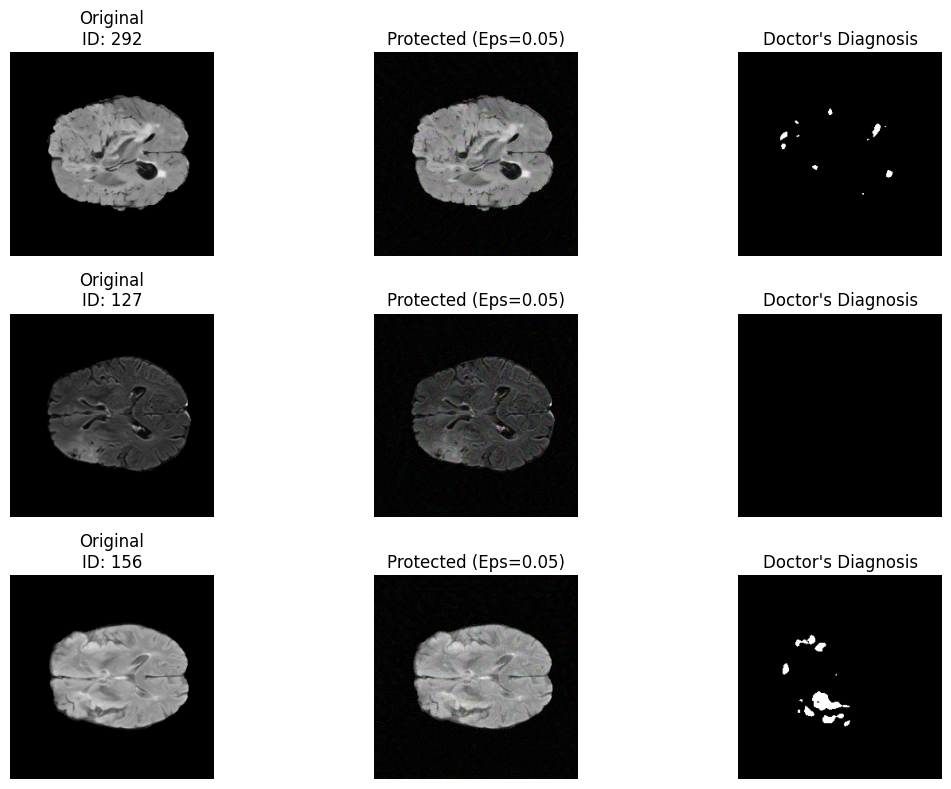

In [22]:
print("GENERATING PRIVACY NOISE...")

real_imgs, p_ids = next(iter(test_attack_loader))
real_imgs, p_ids = real_imgs.to(DEVICE), p_ids.to(DEVICE)

protected_imgs = generate_defense_noise(real_imgs, p_ids, attacker, epsilon=0.05)

with torch.no_grad():
    # Check Attacker on Protected Images
    attr_preds = attacker(protected_imgs)
    _, attr_lbls = torch.max(attr_preds, 1)
    attack_acc = (attr_lbls == p_ids).sum().item() / len(p_ids)

    # Check Doctor on Protected Images
    doc_preds = doctor(protected_imgs)
    doc_preds = (torch.sigmoid(doc_preds) > 0.5).float()

print(f"\nRESULTS OF DEFENSE:")
print(f"Attacker Accuracy (Original): 100.0% (assumed)")
print(f"Attacker Accuracy (Protected): {attack_acc*100:.2f}% (Goal: 0%)")

plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(real_imgs[i].detach().cpu().permute(1, 2, 0))
    plt.title(f"Original\nID: {p_ids[i].item()}")
    plt.axis('off')

    # Protected
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(protected_imgs[i].detach().cpu().permute(1, 2, 0))
    plt.title(f"Protected (Eps=0.05)")
    plt.axis('off')

    # Doctor's View (Prediction)
    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(doc_preds[i][0].detach().cpu(), cmap='gray')
    plt.title("Doctor's Diagnosis")
    plt.axis('off')

plt.tight_layout()
plt.show()

RUNNING FINAL DEFENSE CHECK...


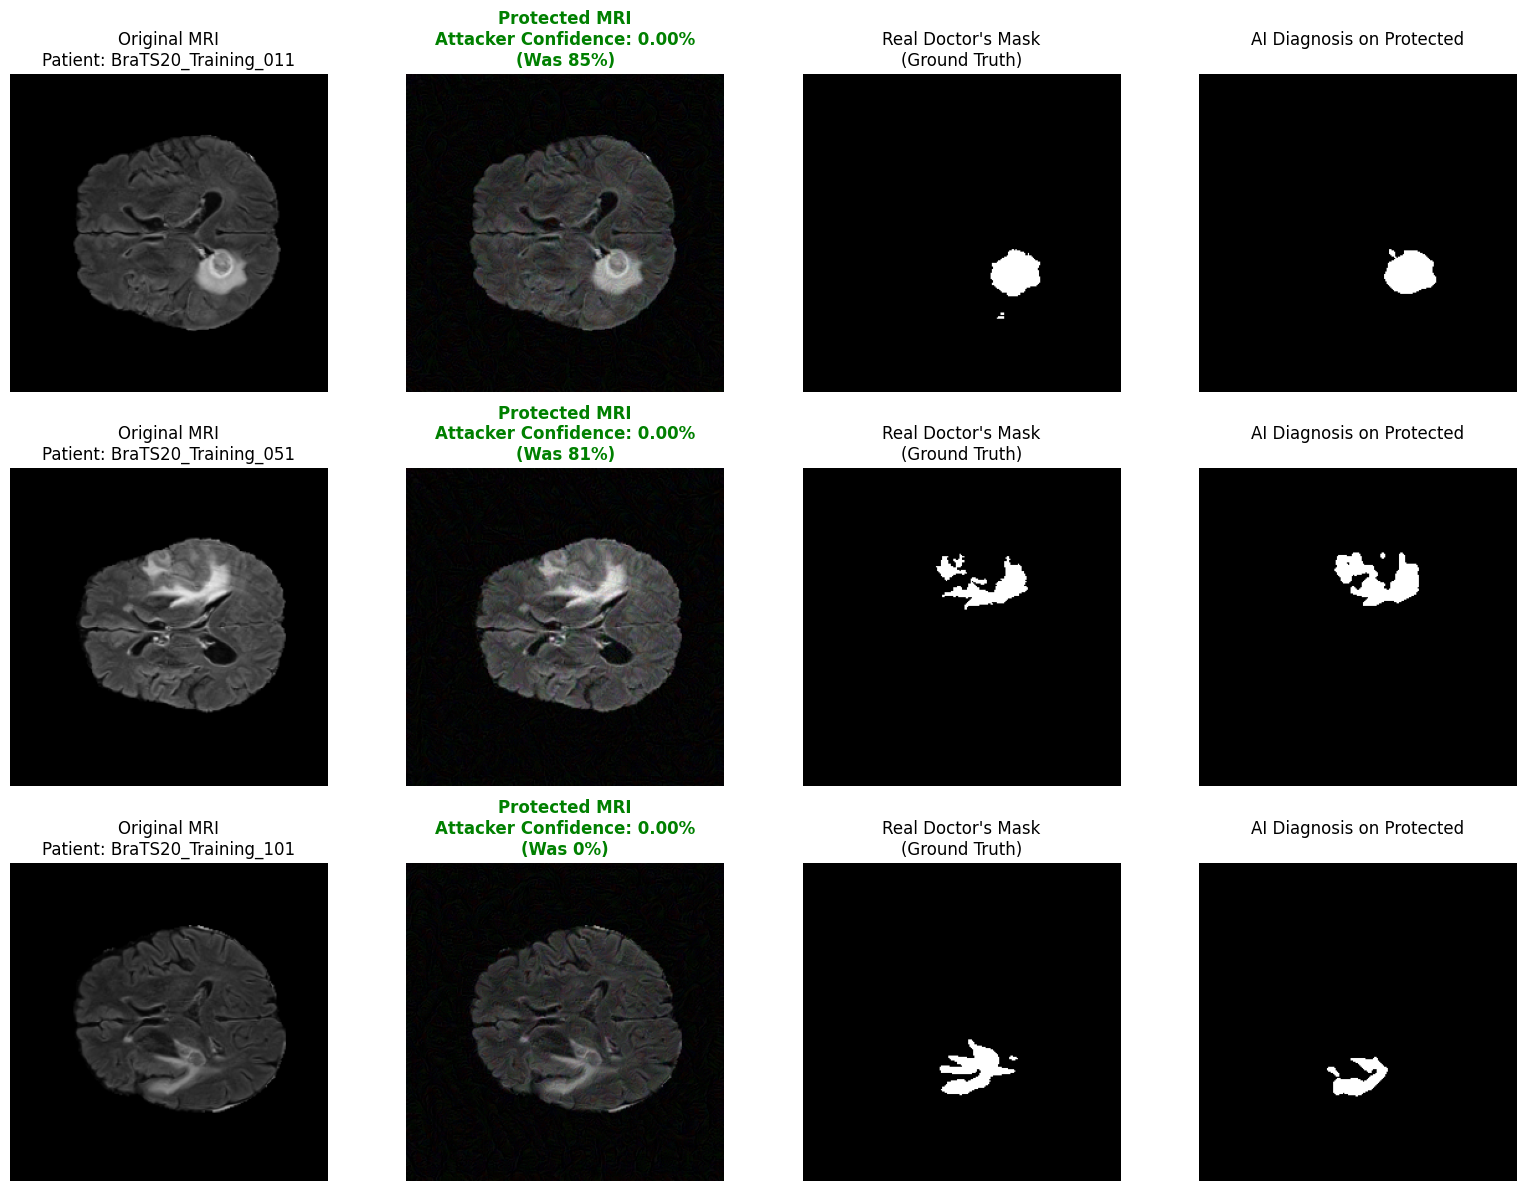

In [23]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel as nib
import cv2
import os

def get_verification_sample(dataset, idx):
    p_dir = dataset.patient_dirs[idx]
    p_id = os.path.basename(p_dir)

    flair_path = os.path.join(p_dir, f"{p_id}_flair.nii")
    flair_vol = nib.load(flair_path).get_fdata()
    slice_idx = flair_vol.shape[2] // 2
    img = flair_vol[:, :, slice_idx]
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
    img = cv2.resize(img, (256, 256))
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0) # Add batch dim

    seg_path = os.path.join(p_dir, f"{p_id}_seg.nii")
    seg_vol = nib.load(seg_path).get_fdata()
    mask = seg_vol[:, :, slice_idx]
    mask = np.where(mask > 0, 1.0, 0.0)
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

    label = torch.tensor([dataset.class_to_idx[p_dir]])

    return img_tensor.to(DEVICE), mask, label.to(DEVICE), p_id

print("RUNNING FINAL DEFENSE CHECK...")

indices = [10, 50, 100]
samples = [get_verification_sample(attack_dataset, i) for i in indices]

plt.figure(figsize=(16, 12))

for i, (real_img, real_mask, label, p_id_str) in enumerate(samples):

    # Generate Privacy Noise (Defense)
    protected_img = generate_defense_noise(real_img, label, attacker, epsilon=0.05)

    # ATTACKER CHECK
    orig_pred = attacker(real_img)
    orig_prob = torch.softmax(orig_pred, dim=1)[0, label].item() * 100

    # Protected Guess
    prot_pred = attacker(protected_img)
    prot_prob = torch.softmax(prot_pred, dim=1)[0, label].item() * 100
    prot_guess_idx = torch.argmax(prot_pred, dim=1).item()

    # DOCTOR CHECK (Utility)
    ai_pred = doctor(protected_img)
    ai_mask = (torch.sigmoid(ai_pred) > 0.5).float().cpu().numpy()[0, 0]

    # Col 1: Original Image
    plt.subplot(3, 4, i*4 + 1)
    plt.imshow(real_img[0].detach().cpu().permute(1, 2, 0))
    plt.title(f"Original MRI\nPatient: {p_id_str}")
    plt.axis('off')

    # Col 2: Protected Image (Attacker Result)
    plt.subplot(3, 4, i*4 + 2)
    plt.imshow(protected_img[0].detach().cpu().permute(1, 2, 0))
    color = "green" if prot_prob < 1.0 else "red"
    plt.title(f"Protected MRI\nAttacker Confidence: {prot_prob:.2f}%\n(Was {orig_prob:.0f}%)", color=color, fontweight='bold')
    plt.axis('off')

    # Col 3: Original Doctor's Mask (Ground Truth)
    plt.subplot(3, 4, i*4 + 3)
    plt.imshow(real_mask, cmap='gray')
    plt.title("Real Doctor's Mask\n(Ground Truth)")
    plt.axis('off')

    # Col 4: AI Prediction on Protected Image
    plt.subplot(3, 4, i*4 + 4)
    plt.imshow(ai_mask, cmap='gray')
    plt.title("AI Diagnosis on Protected\n")
    plt.axis('off')

plt.tight_layout()
plt.show()